In [1]:
%pip install -q python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
from tqdm.auto import tqdm
from dotenv import load_dotenv
from functools import reduce
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, length, max
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
load_dotenv()

True

In [4]:
KEYSPACE = os.environ["CASSANDRA_KEYSPACE"]
IP_ADDRESS = os.environ["CASSANDRA_IP_ADDRESS"]
PORT = os.environ["CASSANDRA_PORT"]
TABLE = "openfoodfacts"
spark_config_apth = 'conf/spark.ini'
IP_ADDRESS, PORT, KEYSPACE, TABLE

('cassandra', '9042', 'mykeyspace', 'openfoodfacts')

In [5]:
config = configparser.ConfigParser()
config.optionxform=str
config.read(spark_config_apth)
list(config['spark'].items())

[('spark.master', 'local[*]'),
 ('spark.driver.memory', '1g'),
 ('spark.executor.memory', '1g'),
 ('spark.executor.instances', '4'),
 ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
 ('spark.dynamicAllocation.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.dynamicAllocation.maxExecutors', '6'),
 ('spark.jars.packages',
  'com.datastax.spark:spark-cassandra-connector_2.12:3.5.1')]

In [6]:
conf = SparkConf()
conf.setAll(list(config['spark'].items()))

In [9]:
spark = SparkSession.builder.config(conf=conf) \
    .config("spark.cassandra.input.fetch.sizeInRows", 1000) \
    .config("spark.cassandra.input.split.sizeInMB", 32) \
    .config("spark.cassandra.query.retry.count", -1) \
    .config("spark.cassandra.connection.host", IP_ADDRESS) \
    .config("spark.cassandra.connection.port", PORT) \
    .getOrCreate()
    
sc = spark.sparkContext

In [10]:
useful_cols = [
    'code',
    'energy_kcal_100g',
    'fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'proteins_100g',
    'salt_100g',
    'sodium_100g',
]

In [11]:
df = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table=TABLE, keyspace=KEYSPACE) \
    .load()
    
df.cache().show(5, False)

Py4JJavaError: An error occurred while calling o58.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 0.0 failed 1 times, most recent failure: Lost task 10.0 in stage 0.0 (TID 10) (d6c6506bf07e executor driver): com.datastax.oss.driver.api.core.servererrors.ReadFailureException: Cassandra failure during read query at consistency LOCAL_ONE (1 responses were required but only 0 replica responded, 1 failed)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: com.datastax.oss.driver.api.core.servererrors.ReadFailureException: Cassandra failure during read query at consistency LOCAL_ONE (1 responses were required but only 0 replica responded, 1 failed)


In [27]:
df.count()

0

In [12]:
len(df.columns)

207

In [13]:
df.rdd.getNumPartitions()

351

In [9]:
df.unpersist()

DataFrame[code: string, abbreviated_product_name: string, acidity_100g: string, added_salt_100g: string, added_sugars_100g: string, additives: string, additives_en: string, additives_n: string, additives_tags: string, alcohol_100g: string, allergens: string, allergens_en: string, alpha_linolenic_acid_100g: string, arachidic_acid_100g: string, arachidonic_acid_100g: string, behenic_acid_100g: string, beta_carotene_100g: string, beta_glucan_100g: string, bicarbonate_100g: string, biotin_100g: string, brand_owner: string, brands: string, brands_en: string, brands_tags: string, butyric_acid_100g: string, caffeine_100g: string, calcium_100g: string, capric_acid_100g: string, caproic_acid_100g: string, caprylic_acid_100g: string, carbohydrates_100g: string, carbon_footprint_100g: string, carbon_footprint_from_meat_or_fish_100g: string, carnitine_100g: string, casein_100g: string, categories: string, categories_en: string, categories_tags: string, cerotic_acid_100g: string, chloride_100g: str

In [25]:
spark.stop()

In [42]:
metadata_cols = ['code']
feature_cols = [c for c in useful_cols if c not in metadata_cols]
feature_cols

['energy-kcal_100g',
 'fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [ ]:
cluster_count = config['model']['k']
seed = config['model']['seed']

kmeans = KMeans(k=cluster_count).setSeed(seed)

In [44]:
cluster_df = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features").transform(df)
cluster_df.show()

+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+--------------------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|            features|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+--------------------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|[332.0,25.0,3.0,1...|
|  2.0|           335.0|     5.6|               7.5|        6.2|          2.3|      0.4|       0.16|[335.0,5.6,7.5,6....|
|  4.0|           100.0|     0.0|              26.0|       15.0|          1.0|      0.0|        0.0|[100.0,0.0,26.0,1...|
|475.0|           222.0|     0.0|              50.8|       50.6|          0.8|      0.0|        0.0|[222.0,0.0,50.8,5...|
|  5.0|           376.0|     1.6|               6.7|        1.3|         82.0|      1.7|       0.68|[376.0,1.6,6.7,1....|
|  6.0|           230.0|

In [45]:
model = kmeans.fit(cluster_df)

In [46]:
model.hasSummary

True

In [47]:
model.summary.k

5

In [48]:
model.summary.clusterSizes

[2291437, 1, 1, 0, 0]

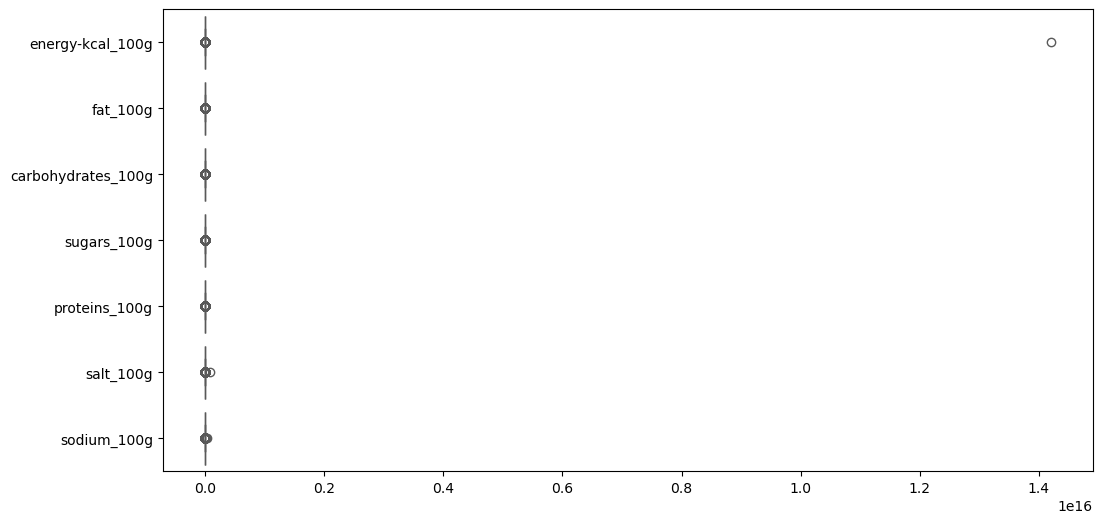

In [49]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(*metadata_cols).toPandas(), orient='h', palette="Set2")
plt.show()

In [51]:
# an energy-amount of more than 1000kcal 
# (the maximum amount of energy a product can have; 
# in this case it would conists of 100% fat)
df = df.filter(col('energy-kcal_100g') < 1000)
df.show()

+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|
|  2.0|           335.0|     5.6|               7.5|        6.2|          2.3|      0.4|       0.16|
|  4.0|           100.0|     0.0|              26.0|       15.0|          1.0|      0.0|        0.0|
|475.0|           222.0|     0.0|              50.8|       50.6|          0.8|      0.0|        0.0|
|  5.0|           376.0|     1.6|               6.7|        1.3|         82.0|      1.7|       0.68|
|  6.0|           230.0|    11.0|              25.0|       0.98|         22.0|     0.95|       0.38|
|  7.0|             1.0|     1.0|               1.0|        1.0|          1.0|      1.0|   

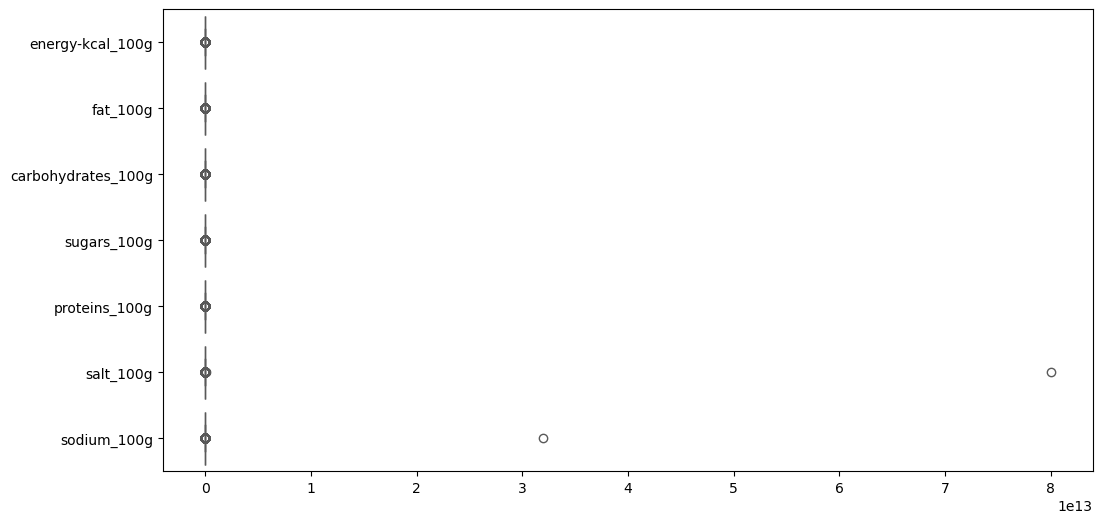

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df.drop(*metadata_cols).toPandas(), 
    orient='h', 
    palette="Set2")
plt.show()

['fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']


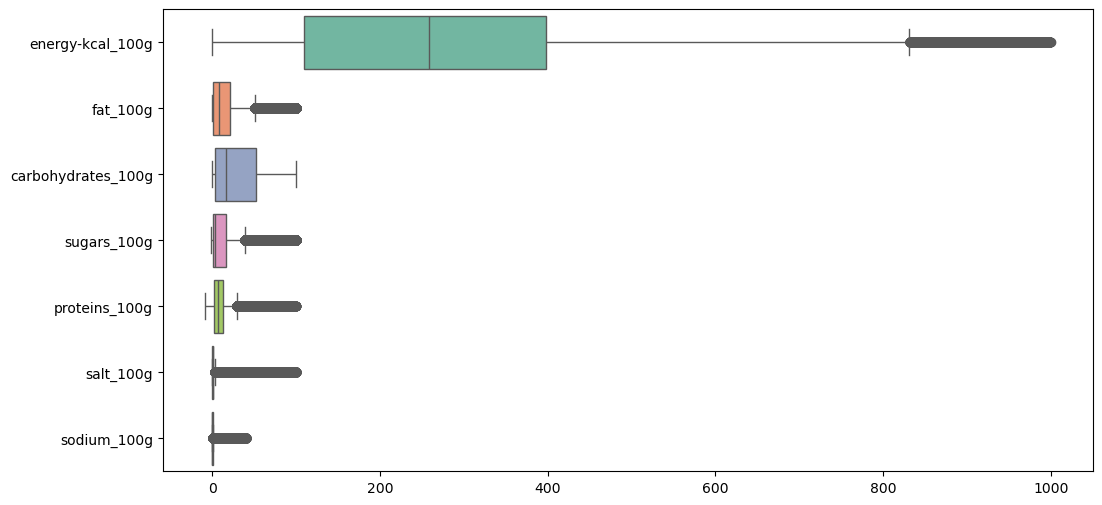

In [55]:
# a feature (except for the energy-ones) higher than 100g
columns_to_filter = [c for c in df.columns if c != 'energy-kcal_100g' and c not in metadata_cols]
print(columns_to_filter)

condition = reduce(
    lambda a, b: a & (col(b) < 100),
    columns_to_filter,
    col(columns_to_filter[0]) < 100 
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df.filter(condition).drop(*metadata_cols).toPandas(), orient='h', palette="Set2")
plt.show()

In [56]:
# a feature (except for the energy-ones) higher than 100g
df = df.filter(condition)
df.show()

+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|
|  2.0|           335.0|     5.6|               7.5|        6.2|          2.3|      0.4|       0.16|
|  4.0|           100.0|     0.0|              26.0|       15.0|          1.0|      0.0|        0.0|
|475.0|           222.0|     0.0|              50.8|       50.6|          0.8|      0.0|        0.0|
|  5.0|           376.0|     1.6|               6.7|        1.3|         82.0|      1.7|       0.68|
|  6.0|           230.0|    11.0|              25.0|       0.98|         22.0|     0.95|       0.38|
|  7.0|             1.0|     1.0|               1.0|        1.0|          1.0|      1.0|   

In [57]:
# a feature with a negative entry
condition = reduce(
    lambda a, b: a & (col(b) >= 0),
    feature_cols,
    col(feature_cols[0]) >= 0 
)
df = df.filter(condition)
df.show()

+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|
|  2.0|           335.0|     5.6|               7.5|        6.2|          2.3|      0.4|       0.16|
|  4.0|           100.0|     0.0|              26.0|       15.0|          1.0|      0.0|        0.0|
|475.0|           222.0|     0.0|              50.8|       50.6|          0.8|      0.0|        0.0|
|  5.0|           376.0|     1.6|               6.7|        1.3|         82.0|      1.7|       0.68|
|  6.0|           230.0|    11.0|              25.0|       0.98|         22.0|     0.95|       0.38|
|  7.0|             1.0|     1.0|               1.0|        1.0|          1.0|      1.0|   

In [58]:
cluster_df = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features").transform(df)
cluster_df.show()

+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+--------------------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|            features|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+--------------------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|[332.0,25.0,3.0,1...|
|  2.0|           335.0|     5.6|               7.5|        6.2|          2.3|      0.4|       0.16|[335.0,5.6,7.5,6....|
|  4.0|           100.0|     0.0|              26.0|       15.0|          1.0|      0.0|        0.0|[100.0,0.0,26.0,1...|
|475.0|           222.0|     0.0|              50.8|       50.6|          0.8|      0.0|        0.0|[222.0,0.0,50.8,5...|
|  5.0|           376.0|     1.6|               6.7|        1.3|         82.0|      1.7|       0.68|[376.0,1.6,6.7,1....|
|  6.0|           230.0|

In [59]:
model = kmeans.fit(cluster_df)

In [60]:
model.summary.clusterSizes

[592510, 363524, 685968, 57432, 549888]

In [65]:
transformed = model.transform(cluster_df).select("features", "prediction")
transformed.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[332.0,25.0,3.0,1...|         0|
|[335.0,5.6,7.5,6....|         0|
|[100.0,0.0,26.0,1...|         2|
|[222.0,0.0,50.8,5...|         4|
|[376.0,1.6,6.7,1....|         0|
|[230.0,11.0,25.0,...|         4|
|[1.0,1.0,1.0,1.0,...|         2|
|[358.0,2.0,6.7,1....|         0|
|[16.0,0.5,2.0,0.2...|         2|
|[428.0,26.5,36.9,...|         0|
|[45.0,13.0,15.0,3...|         2|
|[460.0,24.0,54.0,...|         1|
|[364.0,18.2,27.3,...|         0|
|[356.0,22.2,26.7,...|         0|
|[389.0,16.7,35.2,...|         0|
|(7,[0,2,3],[32.0,...|         2|
|[286.0,5.36,28.6,...|         4|
|[6.0,0.3,0.5,0.2,...|         2|
|[467.0,26.0,51.0,...|         1|
|[126.0,6.1,3.1,0....|         2|
+--------------------+----------+
only showing top 20 rows



In [72]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

In [73]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

print("Before Scaling :")
df.show(5)

for i in feature_cols:
    vect_col_name = f"{i}_Vect" 
    scaled_col_name = f"{i}_Scaled"
    
    assembler = VectorAssembler(
        inputCols=[i], 
        outputCol=vect_col_name)

    scaler = StandardScaler(
        inputCol=vect_col_name, 
        outputCol=scaled_col_name)

    pipeline = Pipeline(stages=[assembler, scaler])

    df = pipeline.fit(df) \
            .transform(df) \
            .withColumn(scaled_col_name, unlist(scaled_col_name)) \
            .drop(vect_col_name)

print("After Scaling :")
df.show(5)

Before Scaling :
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|
|  2.0|           335.0|     5.6|               7.5|        6.2|          2.3|      0.4|       0.16|
|  4.0|           100.0|     0.0|              26.0|       15.0|          1.0|      0.0|        0.0|
|475.0|           222.0|     0.0|              50.8|       50.6|          0.8|      0.0|        0.0|
|  5.0|           376.0|     1.6|               6.7|        1.3|         82.0|      1.7|       0.68|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+
only showing top 5 rows

After Scaling :
+-----+----------------+--------+

In [75]:
scaled_cols = [c for c in df.columns if '_Scaled' in c]
scaled_cols

['energy-kcal_100g_Scaled',
 'fat_100g_Scaled',
 'carbohydrates_100g_Scaled',
 'sugars_100g_Scaled',
 'proteins_100g_Scaled',
 'salt_100g_Scaled',
 'sodium_100g_Scaled']

In [76]:
cluster_df = VectorAssembler(
    inputCols=scaled_cols, 
    outputCol="features").transform(df)
cluster_df.show()

+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+-----------------------+---------------+-------------------------+------------------+--------------------+----------------+------------------+--------------------+
| code|energy-kcal_100g|fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|energy-kcal_100g_Scaled|fat_100g_Scaled|carbohydrates_100g_Scaled|sugars_100g_Scaled|proteins_100g_Scaled|salt_100g_Scaled|sodium_100g_Scaled|            features|
+-----+----------------+--------+------------------+-----------+-------------+---------+-----------+-----------------------+---------------+-------------------------+------------------+--------------------+----------------+------------------+--------------------+
| 63.0|           332.0|    25.0|               3.0|        1.0|         23.0|      1.2|       0.48|                  1.814|          1.546|                     0.11|             0.055|               2.098|  

In [77]:
model = kmeans.fit(cluster_df)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 36246)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.

Py4JError: An error occurred while calling o375.fit

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


In [ ]:
model.summary.clusterSizes

In [ ]:
transformed = model.transform(cluster_df).select("features", "prediction")
transformed.show()

# silhouette_score
 
- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [ ]:
evaluator = ClusteringEvaluator()
evaluator.evaluate(transformed)

0.6787883188237845

In [71]:
model_path = "/sparkdata/kmeans_model"
model.save(model_path)

In [ ]:
spark.stop()